In [1]:
#!pip install --upgrade ~/Development/repos/tradeframework
#!pip install --upgrade ~/Development/repos/quantutils

# import utilities
from MIPriceAggregator.api.aggregator import MarketDataSource, MarketDataAggregator
import quantutils.dataset.pipeline as ppl

#import tradeframework
from tradeframework.api import Derivative, Portfolio, Optimizer, Model, TradeEnvironment, TradeEngine, Asset
from tradeframework.environments import SandboxEnvironment, ZiplineEnvironment
from tradeframework.models import PreOpenMomentum

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


In [2]:
## Get Local Market Data
mds = MarketDataSource("MDSConnector", options={ "remote":True, "location":"http://pricestore.192.168.1.203.nip.io"})
aggregator = MarketDataAggregator([mds])

#assets = {
#    "markets": ["DOW"],
#    "start": "2016-04-19",
#    "end": "2016-11-09"
#}

market = {
    "ID": "DOW"
}

sources = [
    {
        "ID": "WallSt-hourly",
        "sample_unit": "H"
    },
    {
        "ID": "D&J-IND",
        "sample_unit": "5min"
    }
]
    
#start = "2015-01-01"
#end = "2018-08-01"

start = "2013-01-01"
end = "2013-07-11"

ts = aggregator.getData( market, sources, "D", start, end, debug=True)
ts = ppl.removeNaNs(ts)
#ts = ts.tz_convert("US/Eastern", level=0)

#ts = ts.reset_index().set_index("Date_Time")[["Open", "High", "Low", "Close"]]

TypeError: 'MarketDataSource' object is not subscriptable

In [13]:
ts.index.get_level_values("Date_Time").tz

<UTC>

In [3]:
bEnv = SandboxEnvironment("TradeFair", "UTC")
p = bEnv.createPortfolio("Baseline", optimizer=bEnv.createOptimizer("EqualWeights", "EqualWeightsOptimizer"))
bEnv.setPortfolio(p)
#p.addModel(bEnv.createModel( "BuyAndHold", "D3-BuyAndHold", args=("15:00", "16:00")))
p.addAsset(bEnv.createModel("Baseline", "BuyAndHold"))
baseline = bEnv.append(Asset("DOW", ts))

In [4]:
env = SandboxEnvironment("TradeFair")

#opt = env.createOptimizer("KellyOptimizer", "KellyOpt", opts={"window":40*24, "weight":.01})
p = env.createPortfolio("MyPortfolio", optimizer=env.createOptimizer("EqualWeights", "EqualWeightsOptimizer", opts={"weight":1.0}))
env.setPortfolio(p)

# Non-Weighted Portfolio (Indicator)
indicatorP = env.createPortfolio("Indicators")
p.addAsset(indicatorP, weighted=False)
#indicatorP.addAsset(env.createModel( "TrendFollowingIndicator", "TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True} ))
#indicatorP.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#indicatorP.addAsset(env.createModel( "MAXOver", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#indicatorP.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":20, "src_sample":"H", "tgt_sample":"W"} ))
indicatorP.addAsset(env.createModel( "StochOSC1", "StochasticOscXOver", opts={"window":9, "src_sample":"H", "tgt_sample":"W-MON" } ))
indicatorP.addAsset(env.createModel( "StochOSC2", "StochasticOscXOver", opts={"window":9, "src_sample":"H", "tgt_sample":"D"} ))
indicatorP.addAsset(env.createModel( "StochOSC3", "StochasticOscXOver", opts={"window":9, "src_sample":"H", "tgt_sample":"H"} ))
indicatorP.addAsset(env.createModel( "BuyAndHoldIndicator", "BuyAndHold" ))

# Combination Model (using Indicators)
p.addAsset(env.createModel("CombiTrendAndBuy", "CombinationModel", opts={"modelList": [ "StochOSC1", "BuyAndHoldIndicator"]}))

# Custom Models
#p.addAsset(env.createModel( "D1-PreOpenMomentum", "PreOpenMomentum" ))
#p.addAsset(env.createModel( "MA20", "MovingAverage", opts={"ma1_win":20} ))
#p.addAsset(env.createModel( "MAX", "MovingAverageXOver", opts={"ma1_fast":50, "ma2_slow":200} ))
#p.addAsset(env.createModel( "MADaily", "MovingAverageResample", opts={"ma1_win":200, "src_sample":"H", "tgt_sample":"B"} ))
#p.addAsset(env.createModel( "MADailyX", "MovingAverageResampleXOver", opts={"ma1_fast":1, "ma2_slow":12, "src_sample":"H", "tgt_sample":"MS"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":4, "ma2_slow":52, "src_sample":"H", "tgt_sample":"W-MON"} ))
#p.addAsset(env.createModel( "MADailyX2", "MovingAverageResampleXOver", opts={"ma1_fast":50, "ma2_slow":200, "src_sample":"H", "tgt_sample":"D"} ))
#p.addAsset(env.createModel( "StochOSC", "StochasticOscXOver", opts={"window":9, "src_sample":"H", "tgt_sample":"W-MON"} ))

# All hours
#p.addAsset(env.createModel( "D2-BuyAndHold", "BuyAndHold"))

# Market Opening hours only
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold", opts={"start":"09:00", "end":"16:00"}))

# Individual hours
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold6", args=("10:00", "11:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold5", args=("11:00", "12:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold4", args=("12:00", "13:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold3", args=("13:00", "14:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold2", args=("14:00", "15:00")))
#p.addAsset(env.createModel( "BuyAndHold", "D3-BuyAndHold1", args=("15:00", "16:00")))
#p.addAsset(env.createModel("TestModel", "TrendFollowing", opts={"start": "15:00", "end": "16:00", "barOnly": True}))

# ML models
threshold = 0
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '4892e256e17f4fad775119304ee7e6d1', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-BasicBoosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '83c0ff9eeb24c87dbb0af766ab59ef75', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Boosting_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', 'f2efe64bbc39ad0880337120f32ca12b', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_SPY", args=(CredentialsStore(), '3231bbe5eb2ab84eb54c9b64a8dcea55', '078df5a1afbaa2290ee93b4a562e3898', threshold)))
#p.addAsset(env.createModel( "MarketInsightsV2Model", "ML-OneStepAhead_Bootstrap_DOW", args=(CredentialsStore(), '4234f0f1b6fcc17f6458696a6cdf5101', '078df5a1afbaa2290ee93b4a562e3898', threshold)))

#Sandbox
#p.addAsset(env.createModel( "D3-BuyAndHold7", "BuyAndHold"))
#p.addAsset(env.createModel( "D3-BuyAndHold7", "SellAndHold", opts={"start":"09:00", "end":"16:00", "barOnly":"True"}))

# Feed data into the portfolio

#for index in range(0, len(ts)):
#env.handleData(0, ts[:index+1])
dInfo = env.append(Asset("DOW", ts)) 


/home/cwilkin/Development/anaconda/envs/dev/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


(<Figure size 864x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fccc46076d8>)

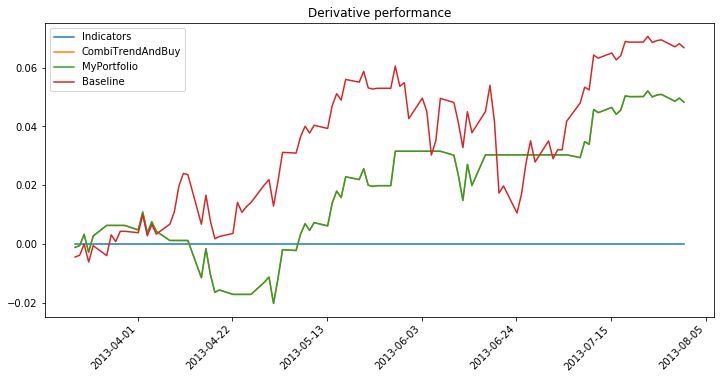

In [5]:
import tradeframework.operations.plot as plotter
#tInfo = env.getTradingInfo(context, dInfo, 10000)
plotter.plotReturns(dInfo, baseline, includeComponents=True, includePrimary=True, log=True)

Notes
 - See how momenutum/trend models work differently when filtered for Buy Only vs Sell Only. This would be due to the nature of slow and steady rises vs swift crashes.

In [8]:
import tradeframework.operations.plot as plotter

plotter.plotWeightedUnderlying(dInfo.assets[1], "DOW")
#plotter.plotUnderlying(dInfo, "DOW")

In [1]:
import numpy as np 
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result[result.size//2:]
    result = result / max(result)
    return result

In [2]:
a = dRet
#a -= np.mean(a)
a = autocorr(a)
a

NameError: name 'dRet' is not defined

In [ ]:
#dRet = dInfo.returns.Close + 1
dRet = trader.getPeriodReturns(dInfo.returns) + 1
#dRet = x.resample('B').agg('prod')
pnl = np.cumprod(dRet)

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(dRet-1, lags=50)
pyplot.show()

In [ ]:
#pyplot.plot(ac_win(dRet))
pyplot.plot(ac_win(dRet, lag=2))
pyplot.show()

In [ ]:
pyplot.plot(pnl.values)
pyplot.show()

In [ ]:
def ac_win(dRet, window=250, lag=1):
    ac = [0] * (window//2)
    for i in range(window, len(dRet)):
        sample = dRet[i-window:i]
        ac.append(autocorr(sample)[lag])
    return ac

In [ ]:

from matplotlib import pyplot
pyplot.plot(tInfo.values[:,0]/10000)
pyplot.show()

In [ ]:

from matplotlib import pyplot
x = np.diff(tInfo.values[:,0]/10000)
lags = 5
ma = np.convolve(x, np.ones((lags,))/lags, mode='same')
pyplot.plot(x,'ro')
pyplot.plot([0] * len(x))
pyplot.plot(ma)
pyplot.show()

In [ ]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
plot_pacf(np.diff(ma), lags=50)
pyplot.show()
adfuller(ma)

In [ ]:

from matplotlib import pyplot
pyplot.plot(np.diff(ma))
pyplot.show()

ValueError: setting an array element with a sequence.

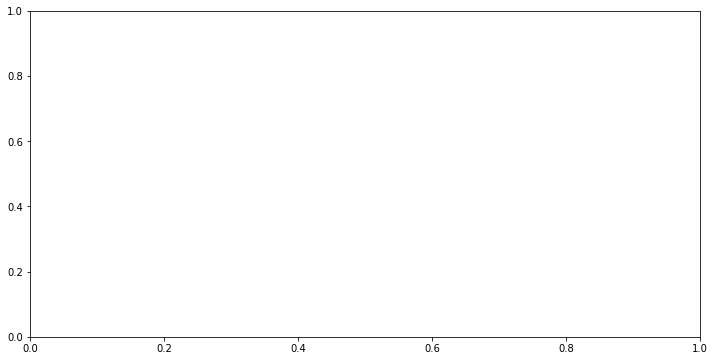

In [15]:

from matplotlib import pyplot
pyplot.plot(ts["Close"])
